In [8]:
# %pip install yfinance

import sys
from typing import List, Tuple
import os as os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
from typing import List, Tuple

def download_adj_close(tickers: dict, 
                       start_date: str = "2020-05-22", 
                       end_date: str = "2025-05-21",
                       output_dir: str = "stock_data") -> pd.DataFrame:
    """
    Downloads Adjusted Close (Adj Close) data for each ticker individually,
    saves them to CSV files, and returns a combined DataFrame.

    Parameters:
        tickers (dict): Dictionary {yfinance_ticker: friendly_name}
        start_date (str): Start date for data download
        end_date (str): End date for data download
        output_dir (str): Directory where CSV files will be saved

    Returns:
        pd.DataFrame: DataFrame with columns = friendly names and rows = dates.
    """

    # Crear directorio si no existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    combined_df = pd.DataFrame()

    print("1) Iniciando descarga individual de tickers...\n")

    for yfinance_ticker, friendly_name in tickers.items():
        try:
            print(f"Descargando datos para {friendly_name} ({yfinance_ticker})...")

            # Descargar Adj Close (sin ajustar)
            data = yf.download(
                yfinance_ticker,
                start=start_date,
                end=end_date,
                auto_adjust=False,
                progress=False
            )["Adj Close"]

            # Normalizar a DataFrame
            df = pd.DataFrame(data)
            df.columns = [friendly_name]

            # Guardar en CSV
            filename = f"{output_dir}/{friendly_name.replace(' ', '_')}.csv"
            df.to_csv(filename)
            print(f" - Archivo guardado en: {filename}")
            print(f" - Observaciones descargadas: {df.shape[0]}\n")

            # Combinar
            combined_df = pd.concat([combined_df, df], axis=1)

        except Exception as e:
            print(f"Error al descargar {friendly_name}: {str(e)}\n")

    print("2) Process completed.\n")
    print("3) Primeras filas del DataFrame combinado:")
    print(combined_df.head())

    return combined_df



def compute_log_returns(adj_close: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    Calcula rendimientos logarítmicos diarios, medias anuales y matriz de covarianza anual.
    Incluye auditoría paso a paso.
    """
    print("\n2) Calculando rendimientos logarítmicos diarios...")
    daily_log_ret = np.log(adj_close / adj_close.shift(1)).dropna()

    print(daily_log_ret.head())

    print("\n3) Media diaria y anualización...")
    annual_mean = daily_log_ret.mean() * 252
    print(annual_mean)

    print("\n4) Matriz de covarianza anual...")
    cov_annual = daily_log_ret.cov() * 252
    print(cov_annual)

    return daily_log_ret, annual_mean, cov_annual


def min_variance_weights(cov_matrix: pd.DataFrame) -> pd.Series:
    """
    Calcula pesos del portafolio de mínima varianza mediante fórmula cerrada:
    
    w = Σ^{-1}1 / (1^T Σ^{-1} 1)
    """
    print("\n5) Calculando pesos del portafolio de mínima varianza...")

    n = len(cov_matrix)
    ones = np.ones(n)

    try:
        sigma_inv = np.linalg.inv(cov_matrix.values)
        print(" - Inversa calculada correctamente.")
    except np.linalg.LinAlgError:
        sigma_inv = np.linalg.pinv(cov_matrix.values)
        print(" - Matriz singular, se usa pseudo-inversa.")

    num = sigma_inv @ ones
    den = ones @ sigma_inv @ ones

    weights = num / den
    weights = pd.Series(weights, index=cov_matrix.index)

    print(" - Suma de pesos:", weights.sum())
    return weights / weights.sum()


def portfolio_metrics(weights: pd.Series, annual_mean: pd.Series, cov_annual: pd.DataFrame,
                      rf= 0.0751) -> dict:
    """
    Calcula retorno esperado, volatilidad y Sharpe.
    """
    print("\n6) Calculando métricas del portafolio...")

    w = weights.values
    mu = annual_mean.loc[weights.index].values
    sigma = cov_annual.loc[weights.index, weights.index].values

    port_return = float(np.dot(w, mu))
    port_vol = float(np.sqrt(w.T @ sigma @ w))
    sharpe = np.nan if port_vol == 0 else (port_return - rf) / port_vol

    print(f" - Retorno anual esperado: {port_return}")
    print(f" - Volatilidad anual: {port_vol}")
    print(f" - Sharpe ratio: {sharpe}")

    return {
        "return": port_return,
        "volatility": port_vol,
        "sharpe": sharpe
    }

In [10]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

def _solve_portfolio_optimization(w, n, mu, sigma, mu_t, allow_short):
    """
    Helper function to solve a single portfolio optimization problem.
    
    Returns the optimal weights if feasible, None otherwise.
    """
    objective = cp.Minimize(cp.quad_form(w, sigma))
    constraints = [cp.sum(w) == 1, mu.T @ w == mu_t]
    if not allow_short:
        constraints.append(w >= 0)
    
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(solver=cp.OSQP, warm_start=True)
    except Exception:
        prob.solve(solver=cp.SCS)
    
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        return None
    
    return np.array(w.value).flatten()

def _cleanup_weights(w_opt, allow_short):
    """
    Clean up numerical errors in weights and normalize.
    """
    if not allow_short:
        w_opt[w_opt < 1e-12] = 0.0
    
    if np.sum(w_opt) == 0:
        return None
    
    return w_opt / np.sum(w_opt)

def _compute_frontier_metrics(w_opt, mu, sigma):
    """
    Compute return and risk for given weights.
    """
    ret = float(mu.T @ w_opt)
    risk = float(np.sqrt(w_opt.T @ sigma @ w_opt))
    return ret, risk

def show_results(mu, sigma, rf = 0.0, tickers=None, targets=500, allow_short=False, ax=None, show_plot=True):
    """
    Compute and plot the efficient frontier using CVXPY.
    Additionally identifies:
        - Minimum variance portfolio
        - Maximum Sharpe ratio portfolio (risk-free = 0)

    Returns a DataFrame with rets, risks, weights, targets,
    and two extra dicts containing the MV and MSR portfolios.
    """

    mu = np.asarray(mu).flatten()
    sigma = np.asarray(sigma)
    n = len(mu)

    # Determine target returns grid
    if hasattr(targets, "__iter__") and not isinstance(targets, (int, np.integer)):
        mu_targets = np.array(targets)
    else:
        mu_min, mu_max = mu.min(), mu.max()
        mu_targets = np.linspace(mu_min, mu_max, int(targets))

    rets, risks, weights_list = [], [], []
    valid_targets = []

    # === Resolver cada punto de la frontera ===
    for mu_t in mu_targets:
        w = cp.Variable(n)
        w_opt = _solve_portfolio_optimization(w, n, mu, sigma, mu_t, allow_short)
        
        if w_opt is None:
            continue

        w_opt = _cleanup_weights(w_opt, allow_short)
        if w_opt is None:
            continue

        ret, risk = _compute_frontier_metrics(w_opt, mu, sigma)

        weights_list.append(w_opt)
        rets.append(ret)
        risks.append(risk)
        valid_targets.append(mu_t)

    rets = np.array(rets)
    risks = np.array(risks)

    # === Identificar portafolio de mínima varianza ===
    idx_min_var = np.argmin(risks)
    min_var_port = {
        "weights": weights_list[idx_min_var],
        "return": rets[idx_min_var],
        "risk": risks[idx_min_var]
    }

    # === Identificar portafolio de máximo Sharpe Ratio ===
    sharpes = (rets - rf) / risks
    idx_max_sharpe = np.nanargmax(sharpes)

    max_sharpe_port = {
        "weights": weights_list[idx_max_sharpe],
        "return": rets[idx_max_sharpe],
        "risk": risks[idx_max_sharpe],
        "sharpe": sharpes[idx_max_sharpe]
    }

    # === Gráfica ===
    if show_plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(9, 6))

        ax.plot(risks, rets, '-o', markersize=4, label='Efficient frontier (CVXPY)', alpha=0.7)

        # Punto de mínima varianza
        ax.scatter(
            min_var_port["risk"], min_var_port["return"],
            marker='X', s=200, color='blue', label='Minimum Variance'
        )

        # Punto de máximo Sharpe
        ax.scatter(
            max_sharpe_port["risk"], max_sharpe_port["return"],
            marker='*', s=250, color='red', label='Maximum Sharpe'
        )

        ax.set_xlabel('Risk (Std. dev.)')
        ax.set_ylabel('Expected return')
        ax.grid(True)
        ax.legend()
        plt.show()

    # === Construcción del DataFrame final ===
    results = pd.DataFrame({
        'rets': rets,
        'risks': risks,
        'weights': weights_list,
        'targets': np.array(valid_targets)
    })

    # Empaquetar portfolios clave
    results.attrs["min_variance"] = min_var_port
    results.attrs["max_sharpe"] = max_sharpe_port
    
    print("\nPortafolio de Máximo Sharpe Ratio:")
    print(f" - Retorno: {max_sharpe_port['return']}")
    print(f" - Riesgo: {max_sharpe_port['risk']}")
    print(f" - Sharpe Ratio PMS: {max_sharpe_port['sharpe']}")

    return results


In [ ]:
tickers = {
	"GAPB.MX": "GAPB",
	"GMEXICOB.MX": "GMEXICOB",
	"KOFUBL.MX": "KOFUBL",
	"ALSEA.MX": "ALSEA",
	"OMAB.MX": "OMAB",
	"CHDRAUIB.MX":"CHDRAUIB",
	"FNOVA17.MX": "FNOVA17",
	"BBAJIOO.MX": "BBAJIOO",
 	"GFINBURO.MX": "GFINBURO" 
}

# Descarga
adj_close = download_adj_close(tickers)

# Cálculos
daily_log, annual_mean, cov_annual = compute_log_returns(adj_close)


1) Iniciando descarga individual de tickers...

Descargando datos para GAPB (GAPB.MX)...
 - Archivo guardado en: stock_data/GAPB.csv
 - Observaciones descargadas: 1257

Descargando datos para GMEXICOB (GMEXICOB.MX)...
 - Archivo guardado en: stock_data/GMEXICOB.csv
 - Observaciones descargadas: 1257

Descargando datos para KOFUBL (KOFUBL.MX)...
 - Archivo guardado en: stock_data/KOFUBL.csv
 - Observaciones descargadas: 1257

Descargando datos para ALSEA (ALSEA.MX)...
 - Archivo guardado en: stock_data/ALSEA.csv
 - Observaciones descargadas: 1257

Descargando datos para OMAB (OMAB.MX)...
 - Archivo guardado en: stock_data/OMAB.csv
 - Observaciones descargadas: 1257

Descargando datos para CHDRAUIB (CHDRAUIB.MX)...
 - Archivo guardado en: stock_data/CHDRAUIB.csv
 - Observaciones descargadas: 1257

Descargando datos para FNOVA17 (FNOVA17.MX)...
 - Archivo guardado en: stock_data/FNOVA17.csv
 - Observaciones descargadas: 1257

Descargando datos para BBAJIOO (BBAJIOO.MX)...
 - Archivo guard

In [12]:
# Optimized weights
weights = min_variance_weights(cov_annual)

# Metrics of the portfolio
metrics = portfolio_metrics(weights, annual_mean, cov_annual, rf=0.0751) #adjust risk-free rate 



5) Calculando pesos del portafolio de mínima varianza...
 - Inversa calculada correctamente.
 - Suma de pesos: 0.9999999999999999

6) Calculando métricas del portafolio...
 - Retorno anual esperado: 0.19976961600095955
 - Volatilidad anual: 0.11377957518775256
 - Sharpe ratio: 1.0957117373240044


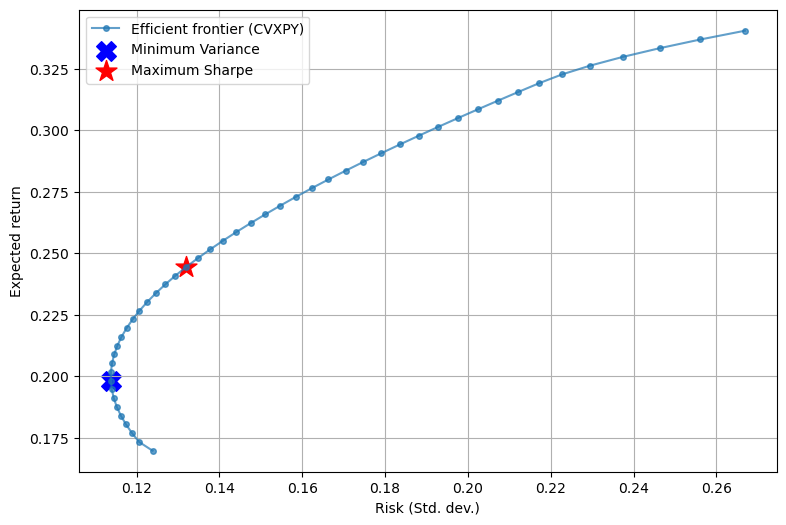


Portafolio de Máximo Sharpe Ratio:
 - Retorno: 0.24451681053719282
 - Riesgo: 0.13199136671872816
 - Sharpe Ratio PMS: 1.2835446343867154


,rets,risks,weights,targets
0,0.169821,0.123878,"[0.0, 0.022379399501448752, 0.2550181951047379...",0.169821
1,0.173378,0.120630,"[0.0, 0.04909185792474395, 0.23090363279394285...",0.173378
2,0.176935,0.118931,"[0.0, 0.047614795633548104, 0.2224838162463217...",0.176935
3,0.180492,0.117463,"[0.0, 0.046067028165519344, 0.2147425172595714...",0.180492
4,0.184048,0.116232,"[0.0, 0.044519260697490654, 0.2070012182728212...",0.184048
5,0.187605,0.115245,"[0.0, 0.04297149322946188, 0.199259919286071, ...",0.187605
6,0.191162,0.114510,"[0.0, 0.041423725761433175, 0.1915186202993208...",0.191162
7,0.194719,0.114030,"[0.0004503609978574522, 0.039852038666629876, ...",0.194719
8,0.198276,0.113801,"[0.0050625016275148375, 0.0380593106380335, 0....",0.198276
9,0.201833,0.113821,"[0.009674642257172357, 0.0362665826094371, 0.1...",0.201833


In [13]:
show_results(annual_mean, cov_annual, rf= 0.0751, tickers=list(tickers.values()), targets=50, allow_short=False)

In [14]:
# IPC Mexico
IPC_ticker = {
    "^MXX" : "IPC"
    }
adj_close_IPC = download_adj_close(IPC_ticker)
daily_log_ret = np.log(adj_close_IPC / adj_close_IPC.shift(1)).dropna()

volatility_IPC = daily_log_ret.std().values[0] * np.sqrt(252)
rendimiento_IPC = daily_log_ret.mean().values[0] * 252

port_vol = metrics['volatility']
ipc_vs_portfolio = (volatility_IPC- port_vol) / volatility_IPC * 100


print("\n=== Benchmark: IPC Mexico ===")
print(f"Volatilidad anual IPC: {volatility_IPC}")
print(f"Rendimiento anual IPC: {rendimiento_IPC}")
print(f"Mejora relativa en volatilidad vs IPC: {ipc_vs_portfolio} %")


1) Iniciando descarga individual de tickers...

Descargando datos para IPC (^MXX)...
 - Archivo guardado en: stock_data/IPC.csv
 - Observaciones descargadas: 1257

2) Process completed.

3) Primeras filas del DataFrame combinado:
                     IPC
Date                    
2020-05-22  35784.421875
2020-05-25  35832.769531
2020-05-26  36206.859375
2020-05-27  36889.960938
2020-05-28  36508.140625

=== Benchmark: IPC Mexico ===
Volatilidad anual IPC: 0.1601749531406424
Rendimiento anual IPC: 0.09796713575423033
Mejora relativa en volatilidad vs IPC: 28.96543875505439 %
